# Particle Track Verification

This notebook is to show the implementation of the particle track code and its validation using MODPATH as comparison.

***to run this script, make sure first to have all dependencies installed and running the scripts 'verification_1.py' and 'verification_2.py', which will create and run the MODFLOW and MODPATH models***


In [4]:
import flopy
import os
import matplotlib.pyplot as plt
import numpy as np
from particle_track import particle_track

## 1. MODEL 1: 2D river bank infiltration model

This is a 2D model where a receiving river is simulated as a constant head models and a well pumps groundwater and induce groundwater inflow.

In this verification we test the particles that infiltrate from the river and arrive at the well and track their traveltime, insuring that the particles arrive after 60 days from infiltration.

Results between particle_track function and MODPATH are compared.




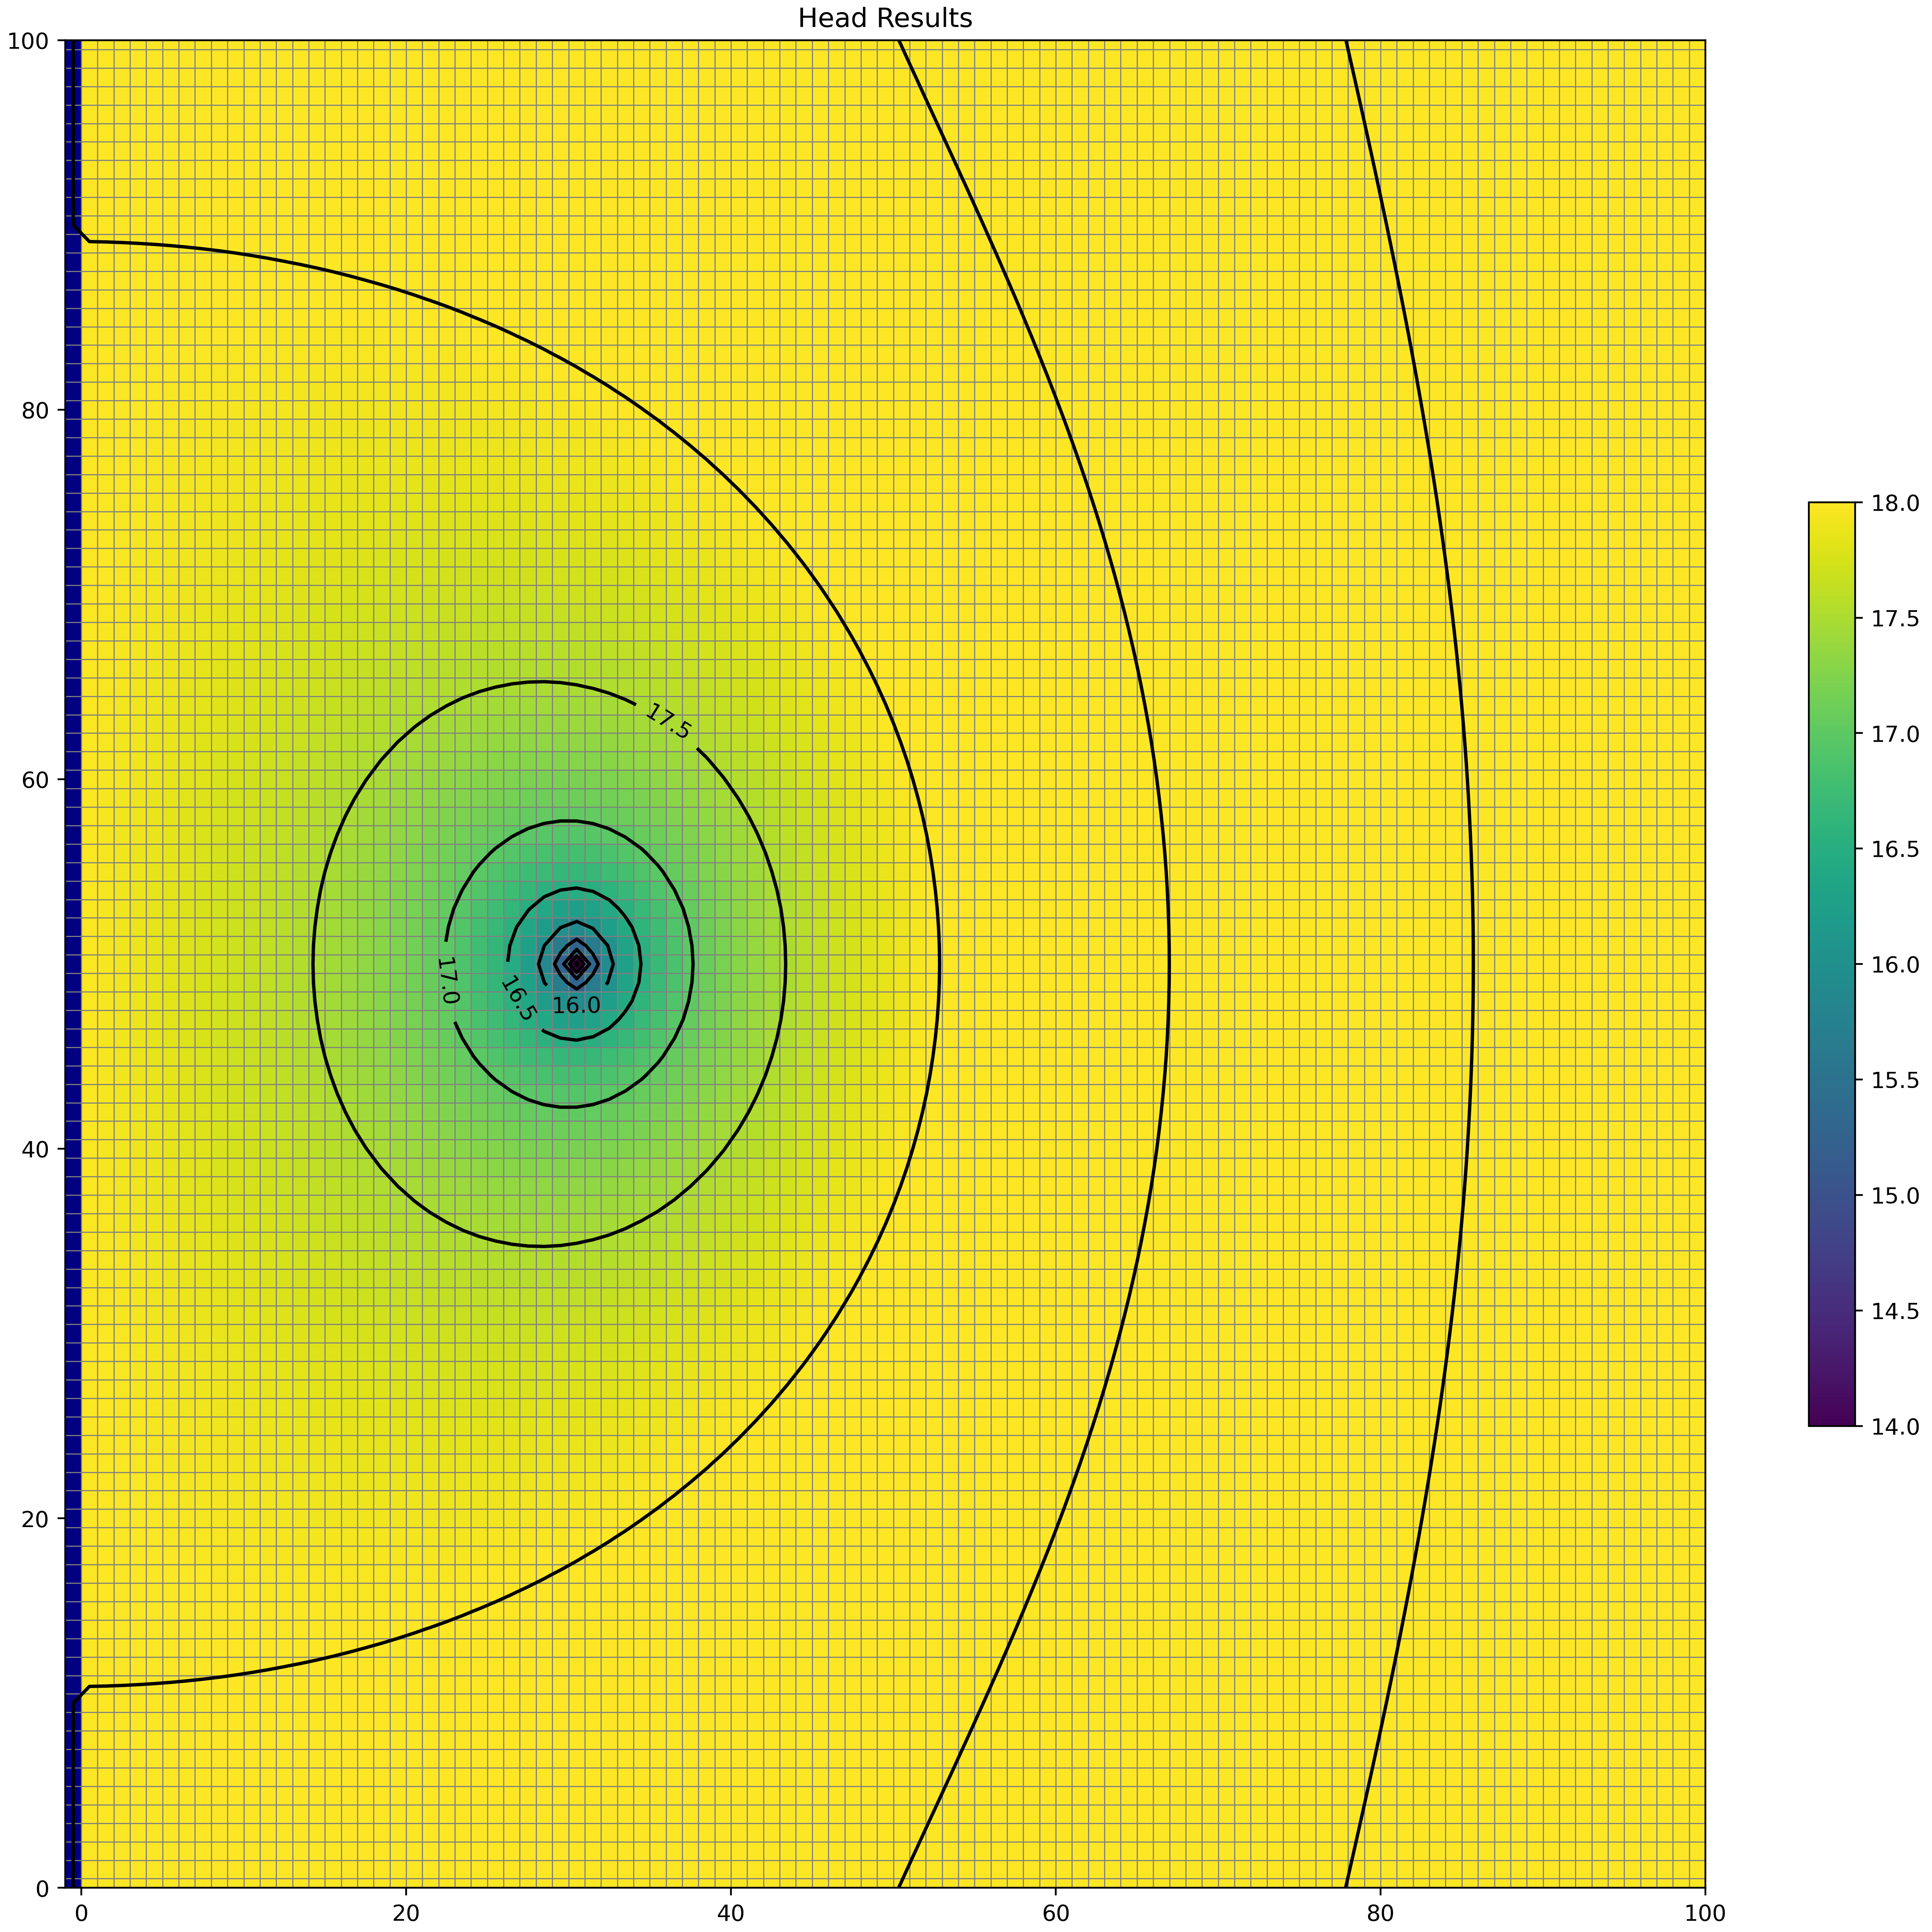

In [5]:
from IPython.display import Image
Image(filename="MODFLOW_testmodels/verification_1_groundwater_heads.png")

### 1.1. Loading MODPATH results

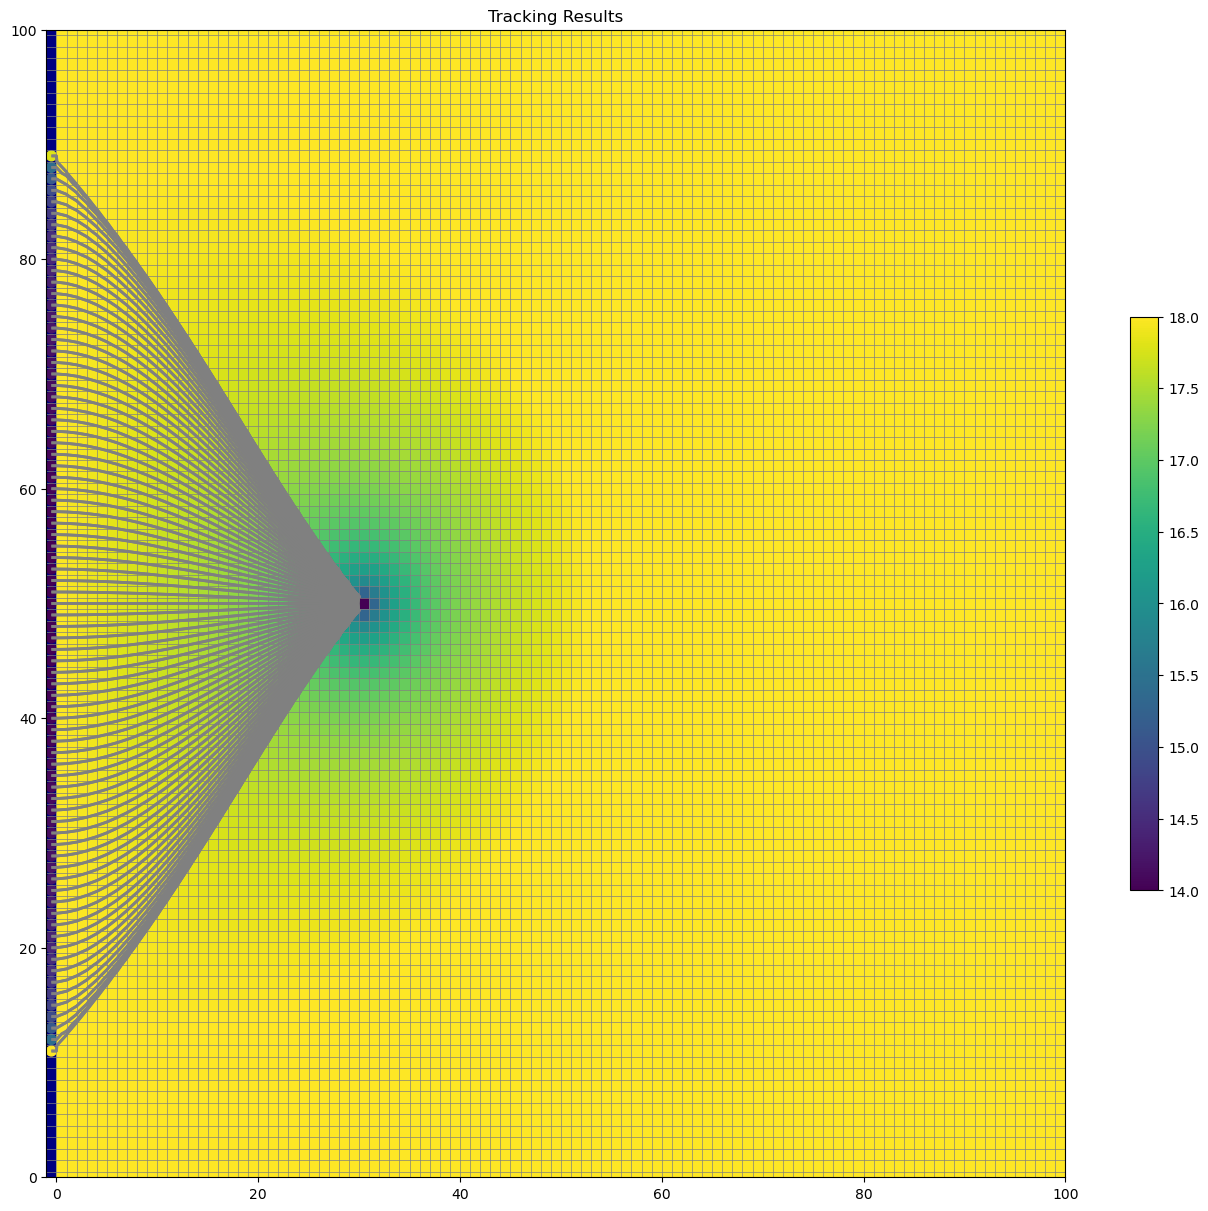

In [7]:
name = 'mf6_verif'
model_directory = "MODFLOW_testmodels/modflow_verification_1"
mpnamf = name + "_mp_forward"

sim = flopy.mf6.MFSimulation.load(
    sim_ws=model_directory,
    exe_name='mf6',
    verbosity_level=0,
)
gwf = sim.get_model(name)
head = gwf.output.head()
head_array = head.get_data()
grid = gwf.modelgrid

# Well cell:
x_well = 30.5
y_well = 50

well_cell = grid.intersect(x_well,y_well)
#Get pathline:
p = flopy.utils.PathlineFile(os.path.join(model_directory,mpnamf + ".mppth"))
e = flopy.utils.EndpointFile(os.path.join(model_directory,mpnamf + ".mpend"))
pw = p.get_destination_pathline_data(dest_cells = grid.get_node((0,well_cell[0],well_cell[1])))
ew = e.get_destination_endpoint_data(dest_cells=grid.get_node((0,well_cell[0],well_cell[1])))

## Plotting Pathline:

fig, ax = plt.subplots(1, 1, figsize=(12, 12), constrained_layout=True)

ax.set_title("Tracking Results")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax, extent = (-1,100,0,100))
pa = modelmap.plot_array(head_array, vmin = 14, vmax = 18)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
modelmap.plot_pathline(pw, layer=0, lw=2)
modelmap.plot_endpoint(ew, direction="starting", colorbar=False)
cb = plt.colorbar(pa, shrink=0.5, ax=ax)
plt.savefig("pathline_fig.png")

# MODPATH travel time results
ttmodpath = e.get_destination_endpoint_data(dest_cells=grid.get_node((0,well_cell[0],well_cell[1])))['time']

### 1.2. Getting starting particle coordinates to use as input in particle track code

In [8]:
X, Y, Z = grid.xyzcellcenters
inds = []
for i in range(len(pw)):
    x = pw[i][0][0]
    y = pw[i][0][1]
    x,y = grid.get_coords(x, y) # convert from local coordinates to global coordinates
    z = pw[i][0][2]
    layer, row, col = grid.intersect(x,y,z)
    inds.append((x,y,z,layer,row,col))

inds = np.vstack(inds)
prts_loc = inds

### 1.3. Runnning the Particle Track

In [10]:
pt_results = particle_track(gwfmodel = gwf, model_directory = model_directory, particles_starting_location = prts_loc)


Processing binary grid file: MODFLOW_testmodels/modflow_verification_1/mf6_verif.dis.grb
  File contains data for NCELLS with shape 
  File contains data for NLAY with shape 
  File contains data for NROW with shape 
  File contains data for NCOL with shape 
  File contains data for NJA with shape 
  File contains data for XORIGIN with shape 
  File contains data for YORIGIN with shape 
  File contains data for ANGROT with shape 
  File contains data for DELR with shape (1000,)
  File contains data for DELC with shape (1000,)
  File contains data for TOP with shape (1000000,)
  File contains data for BOTM with shape (1000000,)
  File contains data for IA with shape (1000001,)
  File contains data for JA with shape (4996000,)
  File contains data for IDOMAIN with shape (1000000,)
  File contains data for ICELLTYPE with shape (1000000,)
Attempting to read 16 records from MODFLOW_testmodels/modflow_verification_1/mf6_verif.dis.grb
  Reading NCELLS
  NCELLS = 1000000
  Reading NLAY
  NLAY

#### 1.3.1. Visual comparison of tracking results

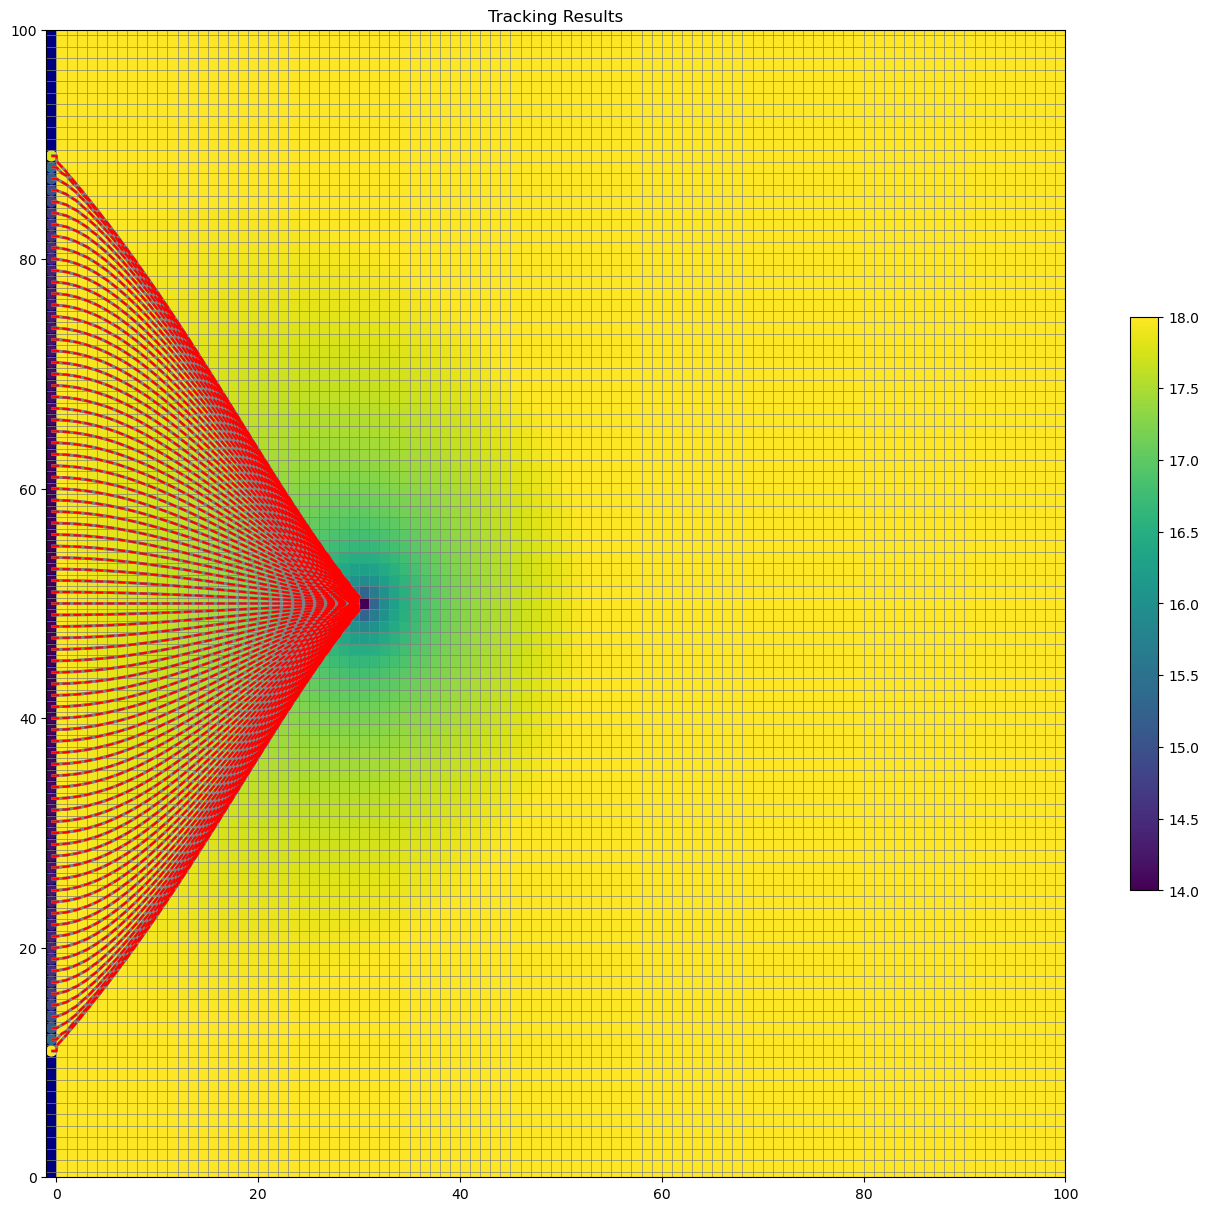

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), constrained_layout=True)
ax.set_title("Tracking Results")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax, extent = (-1,100,0,100))
pa = modelmap.plot_array(head_array, vmin = 14, vmax = 18)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
modelmap.plot_pathline(pw, layer=0, lw=2)
modelmap.plot_endpoint(ew, direction="starting", colorbar=False)
cb = plt.colorbar(pa, shrink=0.5, ax=ax)
ttnumbapath = []
for j in range(np.max(pt_results[:,0]+1).astype(np.int16)):
    results = pt_results[pt_results[:,0] == j, 1:]
    t = results[:,-1]
    x = results[-1,0]
    y = results[-1,1]
    total_t = np.sum(t)
    ttnumbapath.append(total_t)
    ax.plot(results[:,0],results[:,1], '--r')
plt.savefig("pathline_fig_valid.png")

### 1.4. Validation Results

#### 1.4.1. Traveltime comparison

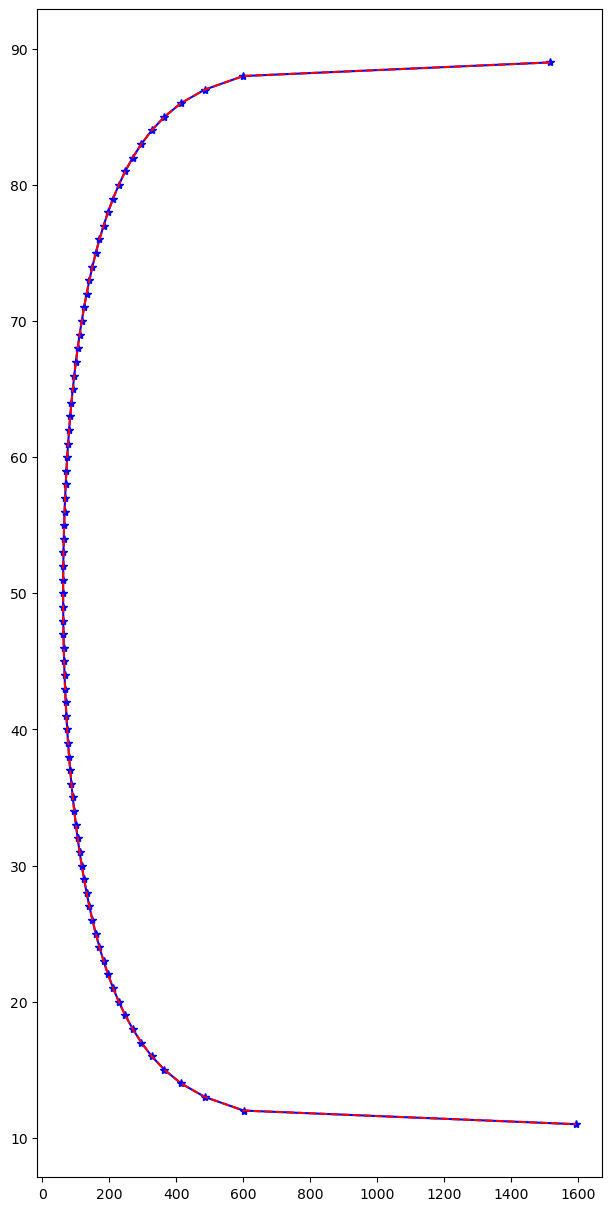

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12), constrained_layout=True)
ax.plot(ttmodpath,prts_loc[:,1],'-*b')
ax.plot(ttnumbapath,prts_loc[:,1],'--r')
fig.savefig('traveltimes_comparison.png')

#### 1.4.2. Residuals

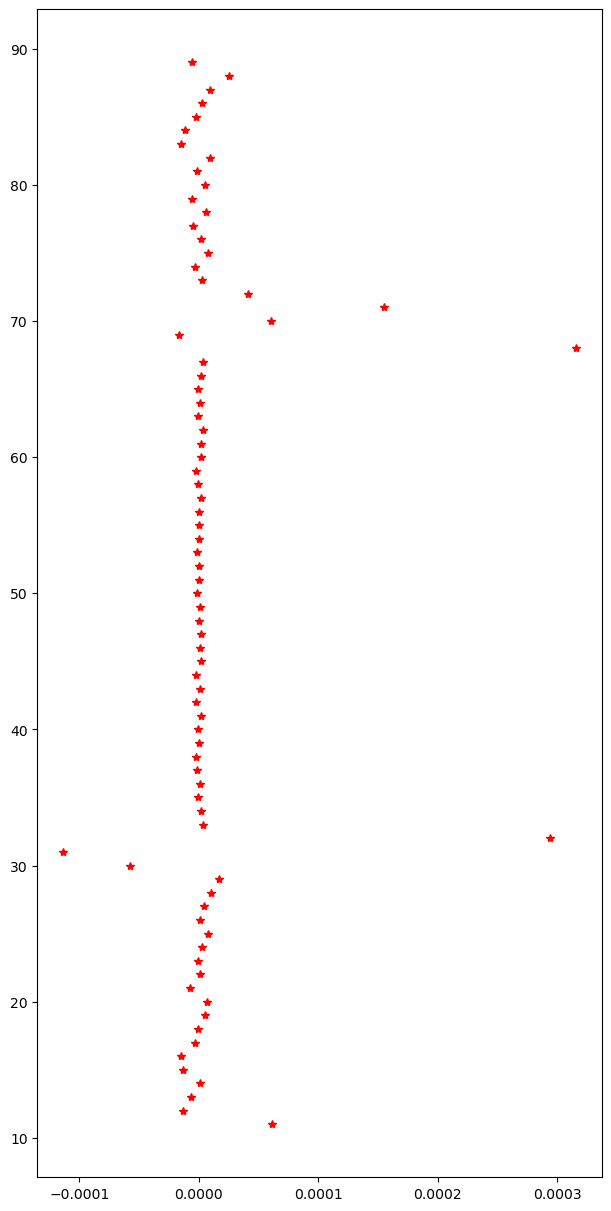

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12), constrained_layout=True)
ax.plot((ttnumbapath-ttmodpath),prts_loc[:,1],'*r')
fig.savefig('traveltimes_residuals.png')

## MODEL 2: 2D Vertical model

This is a 2D cross-section model where, heads are forced at the surface with a linear gradient. A discontinuous low permeability lense is placed in the middle of the cross-section. Complex flow such as local flow zones and regional flow zones are formed in which the particle track code capture it very well.

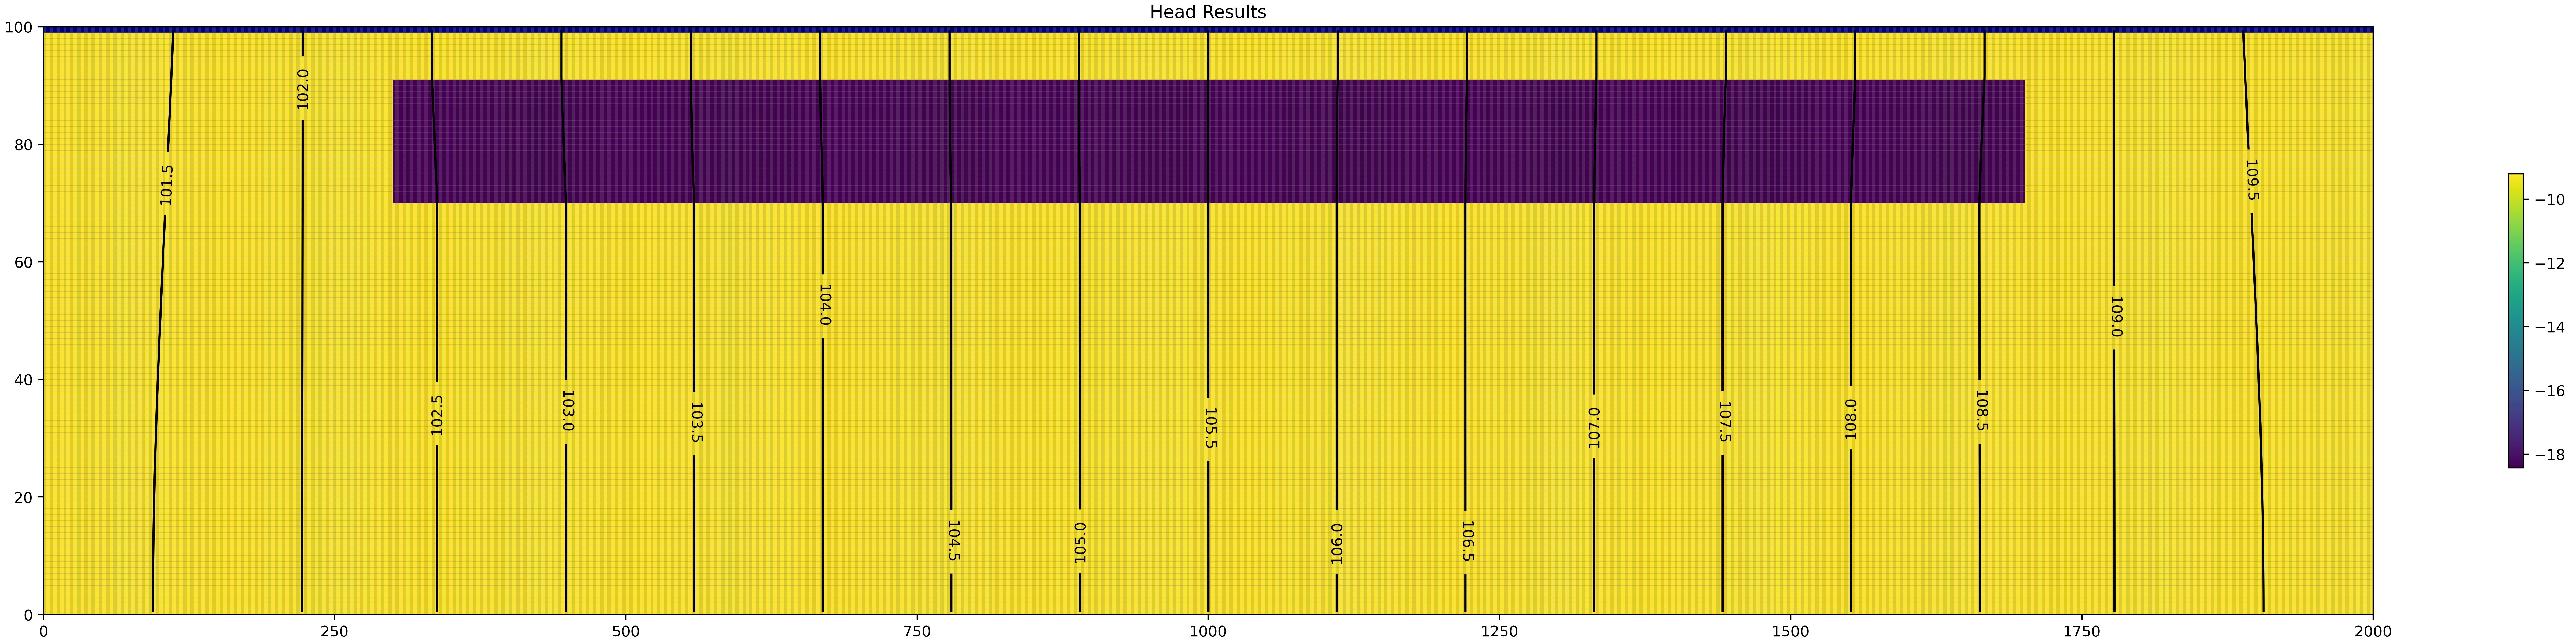

In [15]:
from IPython.display import Image
Image(filename="MODFLOW_testmodels/verification_2_groundwater_heads.png")

### 2.1. Loading MODPATH results

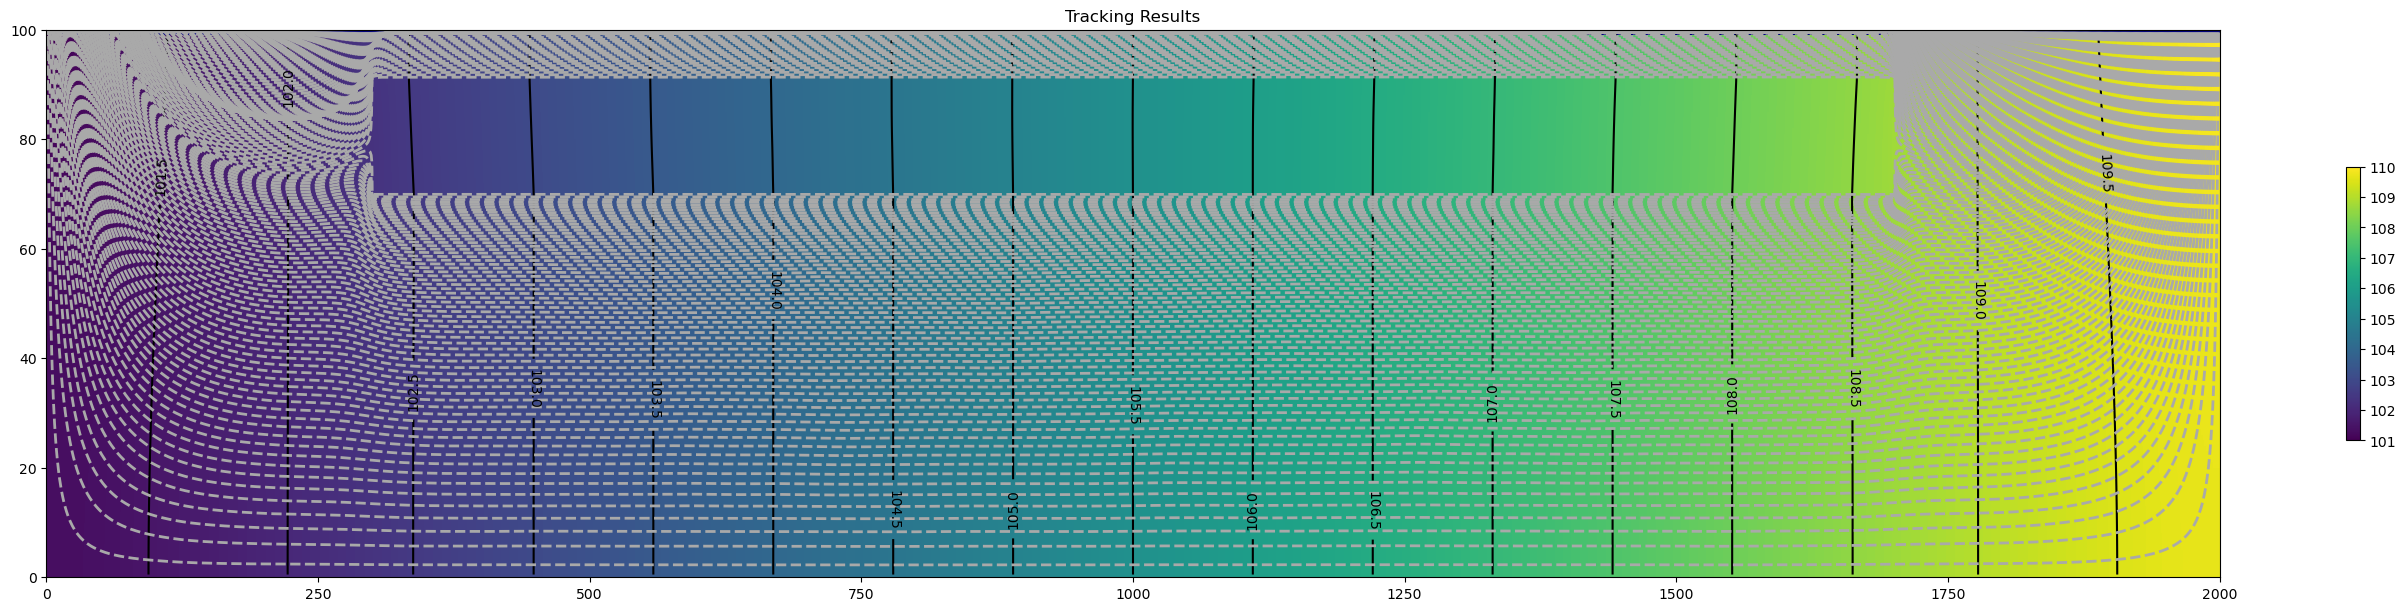

In [25]:
name = 'mf6_verif_2'
model_directory = "MODFLOW_testmodels/modflow_verification_2"
mpnamf = name + "_mp_forward"
sim = flopy.mf6.MFSimulation.load(
    sim_ws=model_directory,
    exe_name='mf6',
    verbosity_level=0,
)
gwf = sim.get_model(name)
head = gwf.output.head()
head_array = head.get_data()
grid = gwf.modelgrid
## reading modpath output

#Get pathline:
p = flopy.utils.PathlineFile(os.path.join(model_directory,mpnamf + ".mppth"))
e = flopy.utils.EndpointFile(os.path.join(model_directory,mpnamf + ".mpend"))
pf = p.get_alldata()

p_sample = []
ttmodpath = []
for i in range(len(pf)):
    x = pf[i]['x']
    z = pf[i]['z']
    time = pf[i]['time']
    p_sample.append((x,z))
    ttmodpath.append(time[-1])
## Plotting Pathline:

fig, ax = plt.subplots(1, 1, figsize=(24, 6), constrained_layout=True)
contour_intervals = np.arange(101, 110, 0.5)
ax.set_title("Tracking Results")
modelmap = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line = {"row": 0})
pa = modelmap.plot_array(head_array)
quadmesh = modelmap.plot_bc("CHD")
#linecollection = modelmap.plot_grid(lw=0.05, color="0.5")
contours = modelmap.contour_array(
    head_array,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)
for i in range(len(p_sample)):
    x = p_sample[i][0]
    z = p_sample[i][1]
    ax.plot(x,z, '--', color = 'darkgrey', linewidth = 2)
#modelmap.plot_endpoint(ew, direction="starting", colorbar=False)
plt.savefig("pathline2_fig.png")

### 2.2. Getting starting particle coordinates to use as input in particle track code

In [36]:
X, Y, Z = grid.xyzcellcenters
inds = []
for i in range(len(pf)):
    x = pf[i][0][0]
    y = pf[i][0][1]
    x,y = grid.get_coords(x, y) # convert from local coordinates to global coordinates
    z = pf[i][0][2]
    layer, row, col = grid.intersect(x,y,z)
    inds.append((x,y,z,layer,row,col))

inds = np.vstack(inds)
prts_loc = inds

### 2.3. Runnning the Particle Track

In [37]:
pt_results = particle_track(gwfmodel = gwf, model_directory = model_directory, particles_starting_location = prts_loc)


Processing binary grid file: MODFLOW_testmodels/modflow_verification_2/mf6_verif_2.dis.grb
  File contains data for NCELLS with shape 
  File contains data for NLAY with shape 
  File contains data for NROW with shape 
  File contains data for NCOL with shape 
  File contains data for NJA with shape 
  File contains data for XORIGIN with shape 
  File contains data for YORIGIN with shape 
  File contains data for ANGROT with shape 
  File contains data for DELR with shape (2000,)
  File contains data for DELC with shape (1,)
  File contains data for TOP with shape (2000,)
  File contains data for BOTM with shape (200000,)
  File contains data for IA with shape (200001,)
  File contains data for JA with shape (995800,)
  File contains data for IDOMAIN with shape (200000,)
  File contains data for ICELLTYPE with shape (200000,)
Attempting to read 16 records from MODFLOW_testmodels/modflow_verification_2/mf6_verif_2.dis.grb
  Reading NCELLS
  NCELLS = 200000
  Reading NLAY
  NLAY = 100
 

#### 2.3.1. Visual comparison of tracking results

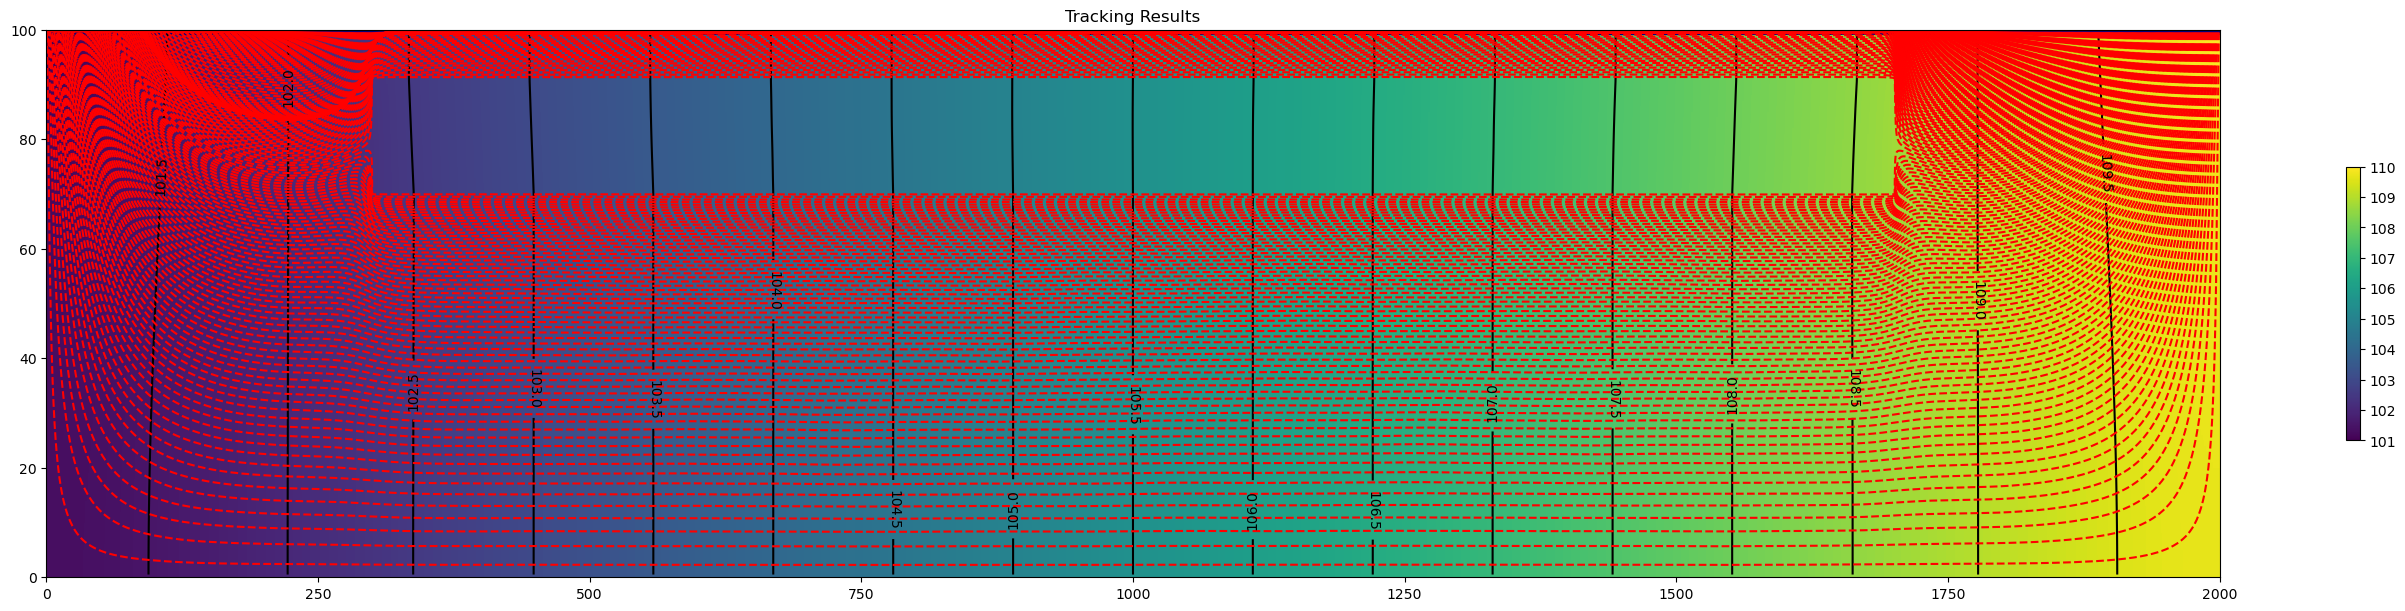

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6), constrained_layout=True)
ax.set_title("Tracking Results")
modelmap = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line = {"row": 0})
pa = modelmap.plot_array(head_array)
quadmesh = modelmap.plot_bc("CHD")
contours = modelmap.contour_array(
    head_array,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)
ttnumbapath = []
for j in range(np.max(pt_results[:,0]+1).astype(np.int16)):
    results = pt_results[pt_results[:,0] == j, 1:]
    t = results[:,-1]
    x = results[-1,0]
    z = results[-1,1]
    total_t = np.sum(t)
    ttnumbapath.append(total_t)
    ax.plot(results[:,0],results[:,2], '--r', linewidth = 1.5)
plt.savefig("pathline_fig_valid_2.png")

### 2.4. Validation Results

#### 2.4.1. Traveltime comparison

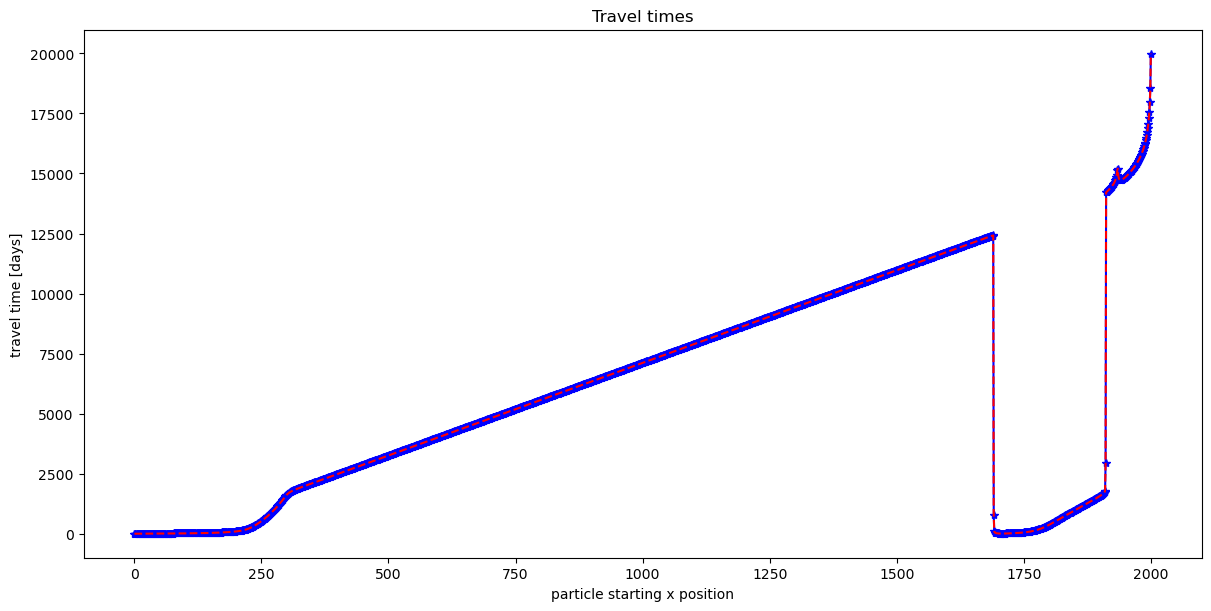

In [42]:
ttnumbapath = np.array(ttnumbapath)
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
ax.plot(prts_loc[:,0],np.array(ttmodpath)/86400,'-*b')
ax.plot(prts_loc[:,0],ttnumbapath/86400,'--r')
ax.set_ylabel('travel time [days]')
ax.set_xlabel('particle starting x position')
ax.set_title('Travel times')
fig.savefig('traveltimes_comparison2.png')

#### 2.4.2. Residuals

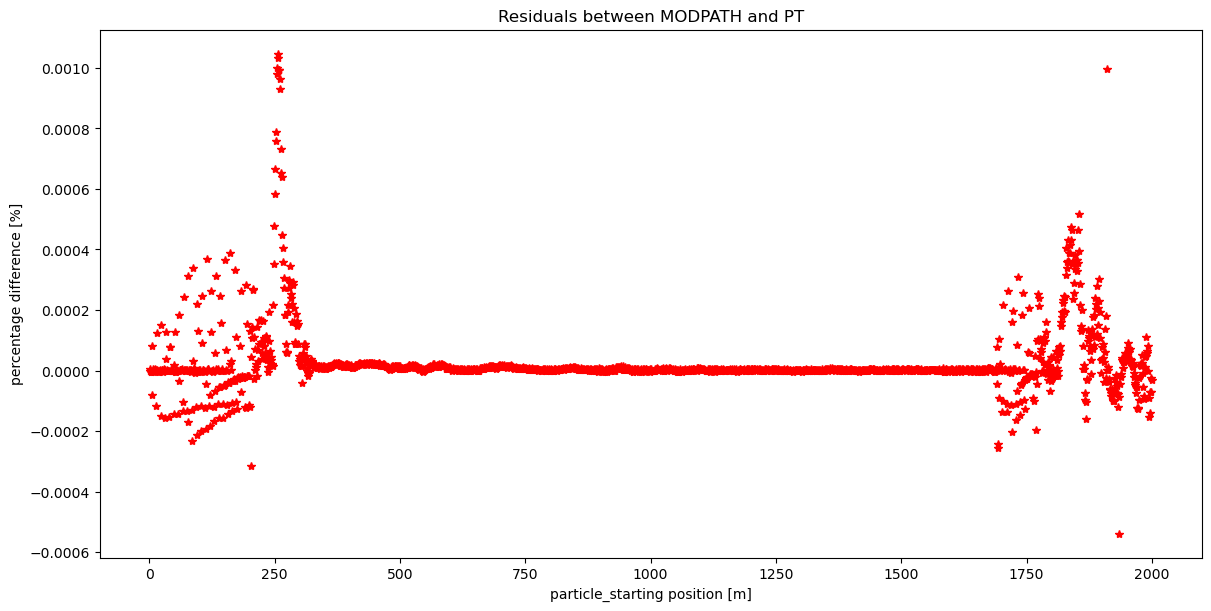

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
ax.plot(prts_loc[:,0],(ttnumbapath-ttmodpath)/ttnumbapath*100,'*r')
ax.set_xlabel('particle_starting position [m]')
ax.set_ylabel('percentage difference [%]')
ax.set_title('Residuals between MODPATH and PT')
fig.savefig('traveltimes_residuals2.png')